# Human Factor Caused Railroad Accidents in US
## Project Goals

* Find potential drivers for human factor caused railroad accidents in the US

* Produce a viable model to predict human factor related railroad accidents based on particular feature input.

* Propose actionable options for the FRA to change policy for railroad companies to further prevent human factor related railroad accidents.

In [1]:
### imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import timedelta, datetime

# .py files
import acquire as acq
import prepare as prep
import explore as exp

#stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu

## Acquire
* Data is pulled from the Federal Railroad Administration (FRA) accident database and loaded as four .csv's ranging from 2019-present day in the directory then joined in Python.
* The initial dataframe loaded contains 9922 rows and 146 columns
* Each row is an accident reported to the FRA
* Each column is a required feature inputed into a form after an accident

## Prepare
* dropped columns containing more than 50% nulls
* converted column strings to lower case
* after research kept columns that seemed most relevant to human performance that can cause accidents. Down to 42 columns and 9900 rows.
* dropped insignificant amount of rows in particular columns missing a couple of key values
* converted most columns to integers
* replaced null values in engineer/conductor hours with the mean because I didn't want to skew the data too far left or right. It is an important feature so I felt it was the best option
* split datframe into train, test, split and X-train, y-train etc. and then scaled the information for two continuous variables
* encoded and created dummies for categorical columns

| Feature          | Definition                                                                       |
|------------------|----------------------------------------------------------------------------------|
| 'date'           | Year, Month, and Day                                                             |
| 'timehr'         | hour of the day (1-12)                                                           |
| 'timemin'        | minute of the hour (0-59)                                                        |
| 'ampm'           | AM or PM indicator                                                               |
| 'type'           | type of train (e.g. freight, passenger, work)                                    |
| 'state'          | state where the incident occured                                                 |
| 'temp'           | temperature in degrees fahrenheight                                              |
| 'visibility'     | visibility measured in miles                                                     |
| 'weather'        | weather conditions (e.g. clear/PC, rain, fog, snow                               |
| 'trnspd'         | train speed in miles per hour                                                    |
| 'tons'           | train weight in tons                                                             |
| 'loadf1'         | load factor (ratio of weight of train to max allowable weight)                   |
| 'emptyf1'        | empty factor (ratio of weight of train to min allowable weight)                  |
| 'cause' = target | cause of incident (e.g. human error, electrical/mechanical, signal, track, misc) |
| 'acctrk'         | contributing factors related to the track                                        |
| 'actrkcl'        | accident classification (e.g. derailment, collision)                             |
| 'enghr'          | number of hours worked by the engineer at the time of the incident               |
| 'condrhr'        | number of hours worked by the conductor at the time of the incident              |

In [2]:
# Read in the first CSV file and keep only the column titles
df = pd.read_csv('RRD_US_2023.csv', nrows=0)

# Loop through the remaining CSV files and stack them on top of the first one
for year in range(2022, 2018, -1):
    filename = f'RRD_US_{year}.csv'
    temp_df = pd.read_csv(filename, header=0)
    df = pd.concat([df, temp_df], axis=0, ignore_index=True)

# Write the combined CSV file to disk
df.to_csv('RRD_US_combined.csv', index=False)

In [3]:
# clean data
df = acq.clean_rrd()

In [4]:
# prepped data
df = prep.prep_rrd_data()

# Look at my data

In [5]:
# look at dataframe
df.head(5)

,incdtno,date,timehr,timemin,ampm,type,state,temp,visiblty,weather,...,weather_rain,weather_snow/hail,acctrkcl_max spd 10mph or less,acctrkcl_max spd 20-25mph,acctrkcl_max spd 25-40mph,acctrkcl_max spd 40-60mph,acctrkcl_max spd 60mph or more,acctrk_leased another railroad,acctrk_owned by carrier,acctrk_trackage rights only
0,UTA022722D,2022-03-06,10,0,AM,Derailment,West Virginia,33,>1/4 mile and <=1/2 mile,Blowing Dirt,...,0,0,1,0,0,0,0,1,0,0
1,0822MA007,2022-08-04,2,10,AM,Hazardous material release,California,81,>1 mile and <=2 miles,Clear/PC,...,0,0,1,0,0,0,0,1,0,0
2,0822MA007,2022-08-04,2,10,AM,Hazardous material release,California,81,>1 mile and <=2 miles,Clear/PC,...,0,0,1,0,0,0,0,1,0,0
3,0922NC005,2022-09-05,11,12,PM,Derailment,Colorado,83,>1 mile and <=2 miles,Rain,...,1,0,0,0,0,0,0,0,1,0
4,0922NC008,2022-09-08,10,30,AM,Derailment,Colorado,73,>1/4 mile and <=1/2 mile,Clear/PC,...,0,0,0,1,0,0,0,0,0,0


In [6]:
# look at info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9900 entries, 0 to 9921
Data columns (total 36 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   incdtno                            9900 non-null   object        
 1   date                               9900 non-null   datetime64[ns]
 2   timehr                             9900 non-null   int64         
 3   timemin                            9900 non-null   int64         
 4   ampm                               9900 non-null   object        
 5   type                               9256 non-null   object        
 6   state                              9689 non-null   object        
 7   temp                               9900 non-null   int64         
 8   visiblty                           9900 non-null   object        
 9   weather                            9900 non-null   object        
 10  trnspd                             9

In [7]:
## A summary of my data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
timehr,9900.0,6.431919,3.486790,1.0,3.0,6.0,9.25,12.0
timemin,9900.0,26.088687,17.600556,0.0,10.0,29.0,40.00,59.0
temp,9900.0,59.465152,21.721108,-36.0,44.0,62.0,76.00,115.0
trnspd,9900.0,11.220101,16.631849,0.0,2.0,5.0,10.00,135.0
tons,9900.0,3347.953535,4976.847329,0.0,0.0,652.0,5195.75,80043.0
loadf1,9900.0,26.706465,37.498195,0.0,0.0,8.0,41.00,294.0
emptyf1,9900.0,17.003636,30.553843,0.0,0.0,1.0,21.00,303.0
enghr,9900.0,4.683030,2.686866,1.0,3.0,4.0,7.00,32.0
cdtrhr,9900.0,4.457071,2.568641,1.0,3.0,3.0,6.00,32.0
cntycd,9900.0,98.572222,100.615165,1.0,31.0,73.0,121.00,800.0


In [8]:
# split and see shape of data
train, val, test = prep.split_data(
    df, train_size=0.6, val_size=0.2, 
    test_size=0.2, random_state=123)
print('Train shape:', train.shape)
print('Validate shape:', val.shape)
print('Test shape:', test.shape)

Train shape: (5939, 36)
Validate shape: (1980, 36)
Test shape: (1980, 36)


## Explore

### Does visibility affect human factor caused accidents?

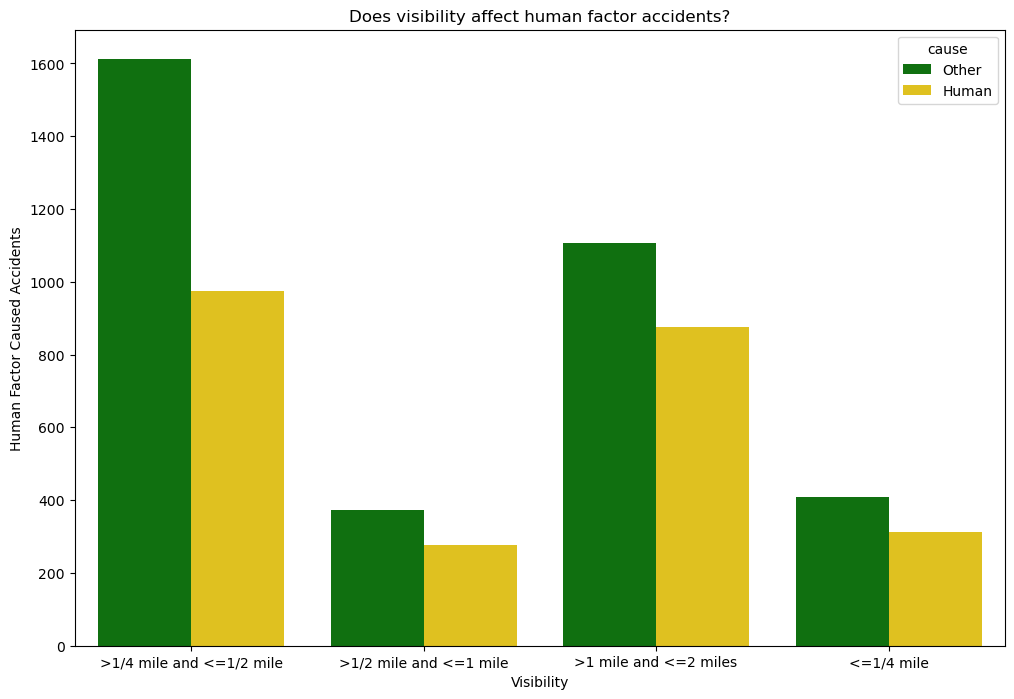

In [9]:
exp.visibility_plot(train)

* Between >= 1/4 mile and <= 1/2 mile visibility it seems more proportional to the population of accidents, however, when visibility  is >= 1/2 mile it looks like it human factor accidents have a larger proportion of the overall accidents.

* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (cause and visibility) in the accident population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.

* $H0$ = There is a relationship between cause and visibility
* $Ha$ = There is a relationship between cause and visibility

In [10]:
# get visibility chi2 stat
exp.visibility_stat(train)

Chi-squared statistic: 22.844968111568704
p-value: 4.350195748698547e-05


* The p-value is less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of a relationship between cause and visibility. We will send it on to modeling.

### Does weather affect human factor caused accidents?

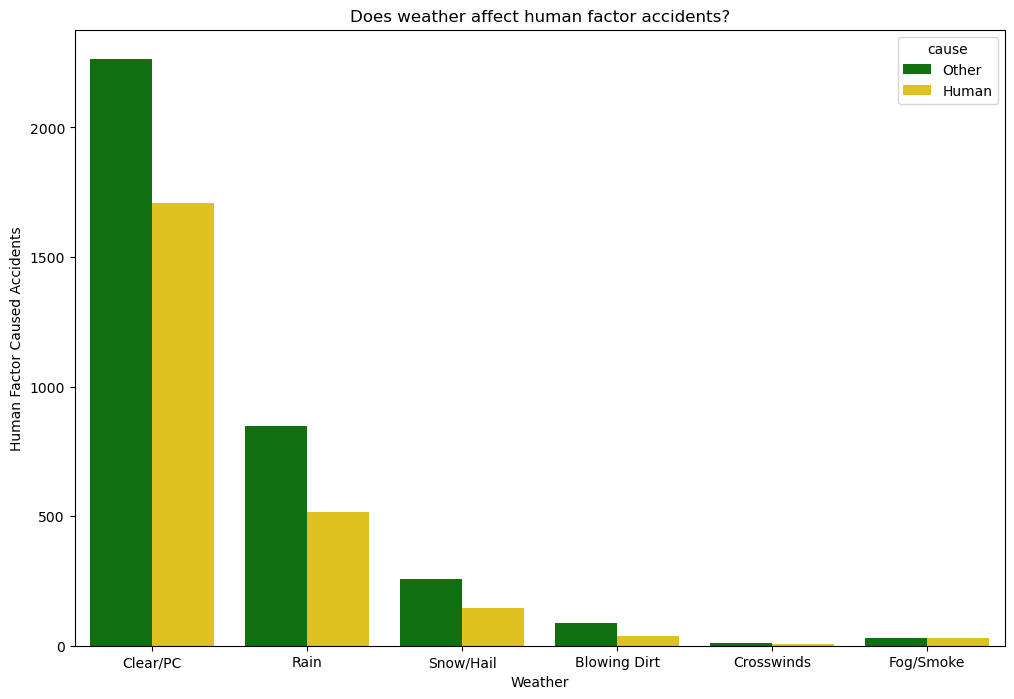

In [11]:
exp.weather_plot(train)

* Looking into the different types of weather in the plot it doesn't seem to have much of a disproportion when compared to clear/pc conditions.

* The chi-squared test of independence tests the null hypothesis that there is no relationship between the two variables (cause and weather) in the accident population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant relationship between the two variables.

* $H0$ = There is a relationship between cause and weather
* $Ha$ = There is a relationship between cause and weather

In [12]:
# get weather chi2 stat
exp.weather_stat(train)

Chi-squared statistic: 24.991392540259763
p-value: 0.00013986800540663016


* The p-value is slightly less than the 0.05 alpha. Therefore we reject the null hypothesis and there is evidence of a weak relationship between cause and visibility. We will send it on to modeling.

### Does conductor work hours affect human factor caused accidents?

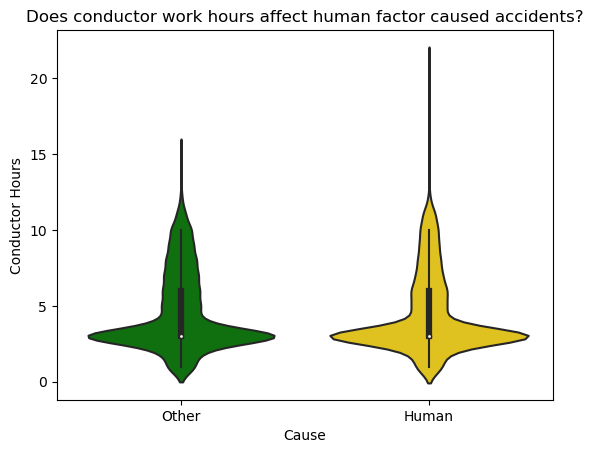

In [13]:
# get conductor hours plot
exp.cdthr_plot(train)

* It seems there is a slightly higher mean for human factor accidents over other.

* The mann_whitney tests the null hypothesis that there is no difference between the means of the two groups (cause and cdtrhr) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant difference between the means of the two groups.

* $H0$ = There is no difference between cdtrhr hours means for those who had human factor accidents and those that were not human factor accidents
* $Ha$ = There is a difference between cdtrhr hours means for those who had human factor accidents and those that were not human factor accidents

In [14]:
# get conductor hours Mann-Whit stat
exp.cdtrhr_stat(train)

Mann-Whitney U test results:
Statistic: 4097801.0
p-value: 0.005661266681436928


* The p-value is less than the 0.05 significance level so we will reject the null hypothesis and will send train conductor hours to modeling

### Does train speed affect human factor caused accidents?

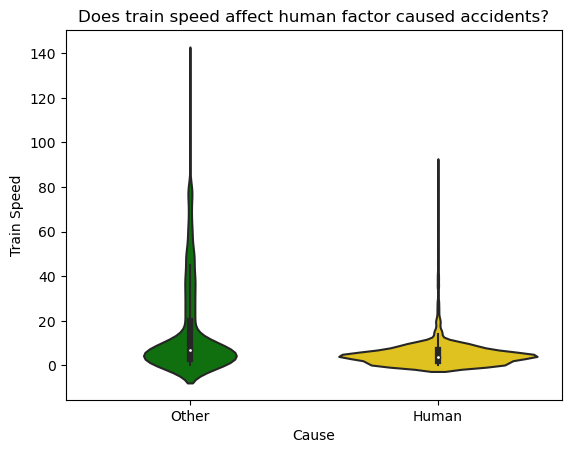

In [15]:
# get trainspeed plot
exp.trnspd_plot(train)

* It visually seems there is no difference concerning trainspeed when it comes to human factor accidents means and actually it looks less than all other accidents.

* The mann-whitney tests the null hypothesis that there is difference between the means of the two groups (cause and trnspd) in the population. If the p-value is less than the significance level (e.g., 0.05), we reject the null hypothesis and conclude that there is a significant difference between the means of the two groups.

* $H0$ = There is no difference between trnspd hours means for those who had human factor accidents and those that were not human factor accidents
* $Ha$ = There is a difference between trnspd hours means for those who had human factor accidents and those that were not human factor accidents

In [16]:
# get trainspeed stat test
exp.trnspd_stat(train)

Mann-Whitney U test results:
Statistic: 3064742.5
p-value: 2.1638787633218512e-77


* The p-value is less than the 0.05 significance level so we reject the null hypothesis and will send train speed to modeling

### Exploration Summary
* visibility has a relationship with cause (human factor) with a p value of: 4.350195748698547e-05
* weather has a weak relationship with cause (human factor) with a p value of: 0.00013986800540663016
* The p-value is less than the 0.05 significance level so we will reject the null hypothesis and will send train conductor hours to modeling. p value: 0.005661266681436928
* The p-value is less than the 0.05 significance level so we reject the null hypothesis and will send train speed to modeling. p value: 2.1638787633218512e-77

## Modeling
* The purpose of modeling the features I have selected is to find the most accurate model for predicting whether or not a human factor related accident will occur.
* The baseline accuracy we are trying to beat is 58%. I will be using a Decision Tree, Random Forest, Logistic Regression, and KNearest models to try to find the best model. I will also be using a grid search to find the optimal hyperparameters with the highest accuracy scores.

### Features I will model
* Visibility
* Weather
* Conductor Hours
* Train Speed

### Prep Data for Modeling

In [17]:
#calculate baseline accuracy
baseline_accuracy = 3498 / (3498+2441)
baseline_accuracy

0.588988045125442

In [18]:
# Get X_train
X_train, X_val, X_test, y_train, y_val, y_test = prep.X_train_data(train, val, test)

In [19]:
# Create X_train scaled
X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test = prep.scaled_data(X_train, X_val, X_test, y_train, y_val, y_test)


### Decision Tree Classifier

In [20]:
# Get Decision Tree Classifier
exp.DTC_model(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

Training Accuracy: 0.6708200033675703
Validation Accuracy: 0.6166666666666667


### Random Forest Classifier

In [21]:
# Get RF Model
exp.RF_model(X_train_scaled, y_train, X_val_scaled,
         y_val, X_test_scaled, y_test)

Training Accuracy: 0.6406802492002021
Validation Accuracy: 0.6378787878787879


### Logistic Regression

In [22]:
# Get LR Model
exp.lr_model(X_train_scaled, y_train, X_val_scaled, 
             y_val, X_test_scaled, y_test)

Training Accuracy: 0.6056575181006904
Validation Accuracy: 0.6181818181818182


### KNN Model

In [23]:
# Get KNN Model
exp.knn_model(X_train_scaled, y_train, X_val_scaled, 
              y_val, X_test_scaled, y_test)

Training Accuracy: 0.6719986529718808
Validation Accuracy: 0.5848484848484848


## Comparing Models
* Baseline: 58.9
* The Decision Tree Model yielded a train accuracy of 67.05 and a validate accuracy of 61.72
* The Random Forest Model yielded a train accuracy of 63.90 and a validate accuracy of 63.94
* The Logistics Regression Model yielded a train accuracy of 60.57 and a validate accuracy of 61.82
* The KNN Model yielded a train accuracy of 67.20 and a validate accuracy of 58.49

## Model Selection
* The Random Forest maintained a 63.92% average accuracy with only a 0.4 differential in both train and validate. The DT and KNN models overfit. All models beat the baseline, but they only moderately beat the baseline. Although, a small accuracy improvement over baseline I feel the Random Forest is the highest accuracy average and consistency. We will move forward with a Random Forest Model using the final test data set.

### Random Forest (Best Model) Test

In [24]:
exp.rf_test_model(X_train_scaled, y_train, X_val_scaled, 
              y_val, X_test_scaled, y_test)

Test Accuracy: 0.6161616161616161


### Modeling Summary
* The Random Forest Model maintained over a 61.62% accuracy between train, validate, and test. The test set scored a 61.62%% and beat the baseline by ~3%.
* I would continue to try and imrove the current model and features as currently it is not a great viable prediction model.

## Conclusions

### Exploration
* The statistical modeling showed some relationships with weather and visibility when compared to a subpopulation of human factor caused accidents. 
* Both p-values for weather and visibility proved a relationship to the human factor cause when compared to against all other cause categories.
* Statistical modeling when comparing the means of conductor hours with human factor causes and conductor hours with other accident causes did did show significance.
* We also found significance when comparing means of train speed with human factor caused accidents and other accidents.
* Weather, visibility, conductor hours, train speed were sent forward for modeling.

### Modeling
* The final Random Forest Model on the test data set decreased accuracy, but beat the baseline by almost 3%.
* It is my opinion there needs to be more viable features added to the models to find any worthy prediction accuracy.

### Recommendations
* The Federal Railroad Administration should consider revamping their accident report forms and policy to include more questions that affect human and job performance on their operators such as:
    * hours of sleep
    * days off
    * training certifications (incomplete or expired)
    * experience level
    * time in that position (new or senior)
* It is important to remember that human factors are the leading railroad accident cause that accounts for ~40% of all accidents. There is always room for improvement when it comes to human related accidents and it's a worthy investment to explore further the causes.

## Next Steps
* If I had more time I would consider bringing in more features such as feature engineering timedate and binning the different shifts into subpopulations.
* Also consider the day of the week the accidents happen such as a weekday versus weekends.